# Cross Entropy Capturing User Preference Changes Implementation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
import itertools

In [2]:
DATA = pd.read_csv('../data/6897-1y-c.csv')

In [3]:
DATA['場次'].isnull().sum()/DATA.shape[0]

0.0365678187939242

## Preprocessing

### Handle Username Formats

In [4]:
def replace_invalid(string):
  string = string.replace('-', '')
  string = string.replace('/', '')
  string = string.replace('*', '')
  string = string.replace(' ', '')
  string = string.replace('劉德玲', '')
  return string

DATA['聯絡電話'] = DATA['聯絡電話'].apply(replace_invalid)

In [5]:
# DATA['user'] = DATA['聯絡電話']

### 處理 period （前六碼）

In [6]:
DATA['period'] = DATA['下單日期'].astype(str).apply(lambda x: x[:6])

### One Hot Encoding
* 處理 category, shipment, payment
* 要先做 label encoding 才能做 one hot encoding

In [7]:
le = LabelEncoder()
DATA['category_label'] = le.fit_transform(DATA['商品分類'])
DATA = pd.concat([DATA, pd.get_dummies(DATA['category_label'], prefix='cat')], axis = 1)

DATA['shipment'] = le.fit_transform(DATA['運送方式'])
DATA['payment'] = le.fit_transform(DATA['付款方式'])
DATA = pd.get_dummies(DATA,
                      prefix=['shipment', 'payment'],
                      columns=['shipment', 'payment'])

### Create `item_id`

In [8]:
# Generating item ids
shuffled_items = DATA['商品名稱'].sample(frac=1).reset_index(drop=True).unique()
item_dict = { x: i for i, x in enumerate(shuffled_items) }

DATA['item_id'] = DATA['商品名稱'].map(item_dict)

### 場次為空
<font color='yellow'>

問題：
1. 有些下單日期與場次不相同，兩個欄位儲存內容的差異？
2. 填入 下單日期 作為場次後，user x streams 的數量為 72,380（有購買紀錄）
   * 如果要讓 user x 所有 stream，資料筆數會從 1,437,160 變成 4,605,980，會產生很多場次屬於 沒有答案 的情境
3. 場次為空的紀錄有 10547 筆，佔 total data 的 0.0366

</font>

In [9]:
DATA['場次'].isnull().sum()/DATA.shape[0], DATA.shape[0]

(0.0365678187939242, 288423)

In [10]:
DATA['場次'] = DATA['場次'].fillna(DATA['下單日期'])

## Constants Needed

In [11]:
LB_CE = [f'cat_{i}' for i in range(228)] + [f'shipment_{i}' for i in range(4)] + [f'payment_{i}' for i in range(2)]
USER_LIST = DATA['聯絡電話'].unique()
STREAM_LIST = DATA['場次'].unique()
STREAM_LIST.sort()

# Creating the row axis labels 
LB_PERIOD = list(DATA['period'].unique())
LB_USER = ['user']
LB_PQ = ['total_price', 'total_quantity']
LB_CAT_DATA = [f'cat_{x}' for x in list(range(228))]
LB_CAT_ITEM = [f'i_cat_{x}' for x in list(range(228))]
LB_SHIPMENT_PAYMENT = ['shipment_0', 'shipment_1', 'shipment_2', 'shipment_3', 'payment_0', 'payment_1']
USER_LB = LB_PERIOD + LB_USER + LB_PQ + LB_SHIPMENT_PAYMENT
LB_ITEMS = ['i_item_id', 'i_avg_price', 'i_count'] + LB_CAT_ITEM


## Context Representation
user x stream data

<font color='yellow'>
如果 context = user + stream + other feature，好像沒有存在的必要
</font>

In [12]:
USER_STREAM_CONTEXT = DATA.groupby(['聯絡電話', '場次']).sum().loc[:, :'payment_1']
USER_STREAM_CONTEXT

下單日期    單價  數量  折扣   總金額  專屬折扣   運費  \
聯絡電話                 場次                                                     
02268052110975092973 20201029.0   20201029   677   1   0   677     0   60   
0266020137           20210718.0   40421436   532  10   0  2660     0  120   
                     20210729.0   80842916  1158   8   0  1274     0    0   
0266213401           20210701.0   40421402   516   2   0   516     0  120   
                     20210711.0   40421422   498   2   0   498     0    0   
...                                    ...   ...  ..  ..   ...   ...  ...   
0989994927           20210606.0  161684849  1696  11   0  1922     0   60   
0989996692           20210314.0   20210314   999   1   0   999     0   60   
                     20210318.0   60630954   586   4   0   765     0    0   
                     20210321.0   60630963  1886   3   0  1886     0   60   
                     20210325.0   80841302  2493   4   0  2493     0    0   

                                 信用卡手續費  紅利折抵  收款金額  ...  cat_224  cat_225  \
聯絡電話                 場次                              ...                     
02268052110975092973 20201029.0       0     0   737  ...        0        0   
0266020137           20210718.0      82     0  4136  ...        0        0   
                     20210729.0       0     0     0  ...        0        0   
0266213401           20210701.0       0     0  1134  ...        0        0   
                     20210711.0       0     0     0  ...        0        0   
...                                 ...   ...   ...  ...      ...      ...   
0989994927           20210606.0       0     0  1982  ...        0        0   
0989996692           20210314.0      37     0  1861  ...        1        0   
                     20210318.0       0     0     0  ...        0        0   
                     20210321.0      89     0  4528  ...        0        0   
                     20210325.0       0     0     0  ...        0        0   

                                 cat_226  cat_227  shipment_0  shipment_1  \
聯絡電話                 場次                                                     
02268052110975092973 20201029.0        0        0           0           1   
0266020137           20210718.0        0        0           0           2   
                     20210729.0        0        0           0           4   
0266213401           20210701.0        0        0           0           2   
                     20210711.0        0        0           0           2   
...                                  ...      ...         ...         ...   
0989994927           20210606.0        0        0           0           8   
0989996692           20210314.0        0        0           1           0   
                     20210318.0        0        0           3           0   
                     20210321.0        0        0           0           3   
                     20210325.0        0        0           0           4   

                                 shipment_2  shipment_3  payment_0  payment_1  
聯絡電話                 場次                                                        
02268052110975092973 20201029.0           0           0          0          1  
0266020137           20210718.0           0           0          2          0  
                     20210729.0           0           0          4          0  
0266213401           20210701.0           0           0          0          2  
                     20210711.0           0           0          0          2  
...                                     ...         ...        ...        ...  
0989994927           20210606.0           0           0          0          8  
0989996692           20210314.0           0           0          1          0  
                     20210318.0           0           0          3          0  
                     20210321.0           0           0          3          0  
                     20210325.0           0           0    

In [13]:
USER_STREAM_CONTEXT.shape, len(DATA['聯絡電話'].unique()), len(DATA['場次'].unique())

((72380, 245), 11778, 391)

In [14]:
USER_STREAM_CONTEXT.index
USER_STREAM_CONTEXT['user'] = USER_STREAM_CONTEXT.apply(lambda x: x.name[0], axis=1)

## Item Representation
- 商品 id 來源為 `item_dict`: `商品名稱: item_id`
- 可用欄位： `categories(one-hot)`, `price`, `被購買次數`
- Columns: `['下單日期', '商品名稱', '規格', '單價', '數量', '折扣', '總金額', '專屬折扣', '運費', '信用卡手續費', '紅利折抵', '收款金額', '付款方式', '運送方式', '收件人', '寄送地址', '聯絡電話', '場次', '處理後名稱', '商品分類', 'period', 'category_label', 0-227, 'shipment_0', 'shipment_1', 'shipment_2', 'shipment_3', 'payment_0', 'payment_1', 'item_id']`

In [15]:
def get_item_df():
  item_df = pd.DataFrame(columns=LB_ITEMS)
  item_df['i_item_id'] = DATA.item_id.unique()
  # Count
  item_count = DATA.groupby('item_id').size()
  item_df['i_count'] = item_df['i_item_id'].apply(lambda x: item_count[x])
  # Cat
  item_df[LB_CAT_ITEM] = DATA.groupby('item_id').sum()[LB_CAT_DATA]
  # Price
  item_df['i_avg_price'] = DATA.groupby('item_id').mean()['單價']
  return item_df

In [16]:
ITEM_DF = get_item_df()

## Generate Item x Stream data
* unique items x each stream
* index: item_id
* column: stream_id

In [17]:
def map_item_stream(item_id):
  in_streams = DATA.loc[DATA.item_id == item_id]['場次'].unique()
  res_series = pd.Series([0]*len(STREAM_LIST))
  res_series.index = STREAM_LIST
  res_series[in_streams] = 1
  return res_series

In [18]:
ITEM_STREAM_DF = pd.DataFrame(index=DATA.item_id.unique(), columns=DATA['場次'].unique())
ITEM_STREAM_DF = ITEM_STREAM_DF.apply(lambda x: map_item_stream(x.name), axis=1, result_type='expand')

## [Reward] Generate Real Bought DF

In [19]:
REAL_BOUGHT_DF = DATA.loc[:, ['聯絡電話', '場次', 'item_id']]

## [Action] User bought last stream

In [20]:
LAST_BOUGHT_STREAM = USER_STREAM_CONTEXT.reset_index().groupby('聯絡電話', as_index=False).last().loc[:, ['聯絡電話', '場次']].set_index('聯絡電話')

---
### Test Area

In [29]:
USER_STREAM_CONTEXT


下單日期    單價  數量  折扣   總金額  專屬折扣   運費  \
聯絡電話                 場次                                                     
02268052110975092973 20201029.0   20201029   677   1   0   677     0   60   
0266020137           20210718.0   40421436   532  10   0  2660     0  120   
                     20210729.0   80842916  1158   8   0  1274     0    0   
0266213401           20210701.0   40421402   516   2   0   516     0  120   
                     20210711.0   40421422   498   2   0   498     0    0   
...                                    ...   ...  ..  ..   ...   ...  ...   
0989994927           20210606.0  161684849  1696  11   0  1922     0   60   
0989996692           20210314.0   20210314   999   1   0   999     0   60   
                     20210318.0   60630954   586   4   0   765     0    0   
                     20210321.0   60630963  1886   3   0  1886     0   60   
                     20210325.0   80841302  2493   4   0  2493     0    0   

                                 信用卡手續費  紅利折抵  收款金額  ...  cat_225  cat_226  \
聯絡電話                 場次                              ...                     
02268052110975092973 20201029.0       0     0   737  ...        0        0   
0266020137           20210718.0      82     0  4136  ...        0        0   
                     20210729.0       0     0     0  ...        0        0   
0266213401           20210701.0       0     0  1134  ...        0        0   
                     20210711.0       0     0     0  ...        0        0   
...                                 ...   ...   ...  ...      ...      ...   
0989994927           20210606.0       0     0  1982  ...        0        0   
0989996692           20210314.0      37     0  1861  ...        0        0   
                     20210318.0       0     0     0  ...        0        0   
                     20210321.0      89     0  4528  ...        0        0   
                     20210325.0       0     0     0  ...        0        0   

                                 cat_227  shipment_0  shipment_1  shipment_2  \
聯絡電話                 場次                                                        
02268052110975092973 20201029.0        0           0           1           0   
0266020137           20210718.0        0           0           2           0   
                     20210729.0        0           0           4           0   
0266213401           20210701.0        0           0           2           0   
                     20210711.0        0           0           2           0   
...                                  ...         ...         ...         ...   
0989994927           20210606.0        0           0           8           0   
0989996692           20210314.0        0           1           0           0   
                     20210318.0        0           3           0           0   
                     20210321.0        0           0           3           0   
                     20210325.0        0           0           4           0   

                                 shipment_3  payment_0  payment_1  \
聯絡電話                 場次                                             
02268052110975092973 20201029.0           0          0          1   
0266020137           20210718.0           0          2          0   
                     20210729.0           0          4          0   
0266213401           20210701.0           0          0          2   
                     20210711.0           0          0          2   
...                                     ...        ...        ...   
0989994927           20210606.0           0          0          8   
0989996692           20210314.0           0          1          0   
                     20210318.0           0          3          0   
                     20210321.0           0          3          0   
                     20210325.0           0          4          0   

                                                 user  
聯絡電話                 場次   

In [22]:
ITEM_DF.columns

Index(['i_item_id', 'i_avg_price', 'i_count', 'i_cat_0', 'i_cat_1', 'i_cat_2',
       'i_cat_3', 'i_cat_4', 'i_cat_5', 'i_cat_6',
       ...
       'i_cat_218', 'i_cat_219', 'i_cat_220', 'i_cat_221', 'i_cat_222',
       'i_cat_223', 'i_cat_224', 'i_cat_225', 'i_cat_226', 'i_cat_227'],
      dtype='object', length=231)

In [23]:
USER_STREAM_CONTEXT['user']

聯絡電話                  場次        
02268052110975092973  20201029.0    02268052110975092973
0266020137            20210718.0              0266020137
                      20210729.0              0266020137
0266213401            20210701.0              0266213401
                      20210711.0              0266213401
                                            ...         
0989994927            20210606.0              0989994927
0989996692            20210314.0              0989996692
                      20210318.0              0989996692
                      20210321.0              0989996692
                      20210325.0              0989996692
Name: user, Length: 72380, dtype: object

---
## Train DQN model
* Input: `user_df` 253, `item_df` 231(BERT: 768), interact (?), `reward` 1
* Output: recommend a list of items
* Methods Needed
    * Environment Function
    * Choose Action
    * Store Transition
    * Learn

### Environment
Get full state

<font color='yellow'>

* 參考原論文: user _interest 初始值為 random vector
1. 很多筆記錄裡用戶只在一場直播裡購買，如果 random 的話 accuracy 會下降
2. 不可能用該期直播的相關紀錄作為 state → 在 user/state context 裡加上 RFML/streamer information
3. user x all_stream → 在第一場直播都給予 random vector，對 accuracy 的影響就不會太高（？

</font>

In [24]:
'''
Generate series: whether elements in A existed in list B
A, B: List
return: pd.Series
example:
  A: [1, 2, 4, 5]
  B: [1, 2, 3, 4, 5, 6, 7]
  return: Series([1, 1, 0, 1, 1, 0, 0], index=[1, 2, 3, 4, 5, 6, 7])
'''
def gen_exist_series(A, B):
  exist_list = [int(item in A) for item in B]
  return pd.Series(exist_list, index=B)


USER_ALL_STREAM_INIT = USER_STREAM_CONTEXT.describe().loc['50%']

def get_full_state(user_all_streams, stream_list, i):
  # Get full state: current_state = user_stream + item_stream
  # 第一次參加直播/cold start
  # CE paper: user_interest part init with random vector
  # TODO init with random values
  #      Cold start problem
  # USER PART
  user_part = USER_ALL_STREAM_INIT.copy() if (i - 1) == -1 else user_all_streams.loc[stream_list[(i - 1)]]
  user_part['user'] = user_all_streams['user'].to_list()[0]

  # ITEMS PART
  # Get all items from stream
  # USER_PART + ITEM_PART
  full_state_stream_items = ITEM_STREAM_DF.loc[ITEM_STREAM_DF[stream_list[i]] == 1].index.to_list()
  user_part['cand_item'] = full_state_stream_items
  return user_part


'''
Comparison function for reward
'''
def r(a, b):
  if a==1 and b==0: return -1
  else: return a & b

def get_reward(user_phone, stream, action_ids):
  items = action_ids.index
  real_bought_ids = REAL_BOUGHT_DF.loc[(REAL_BOUGHT_DF['聯絡電話'] == user_phone) 
                                         & (REAL_BOUGHT_DF['場次'] == stream)]['item_id'].values
  real_bought_ids_series = gen_exist_series(real_bought_ids, items)
  
  reward_list = [r(a, b) for a, b in zip(real_bought_ids_series.values, action_ids.values)]
  return pd.Series(reward_list, index=items)


from sklearn.metrics import log_loss

def calculate_interest_change(user_all_streams, stream_list, i):
  if i < 0:
    return 0
  else:
    former_stream = stream_list[i-1]
    current_stream = stream_list[i]

    test_ce = user_all_streams.loc[:, LB_CE]
    ce = log_loss(test_ce.loc[former_stream], test_ce.loc[current_stream], labels=['prev', 'current'])
    if ce < 0.01: ce = 0
    else: ce = round(ce, 3)
    return ce

In [25]:
INPUT_DF_COL__USR = USER_STREAM_CONTEXT.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS

'''
Convert state format to model input format
'''
def get_input(input_state):
  # Slice items
  items = input_state['cand_item']
  input_state = input_state.drop('cand_item')
  item_feat = ITEM_DF.loc[items]
  
  # Create new dataframe
  stream_item_feat = pd.DataFrame(columns=INPUT_DF_COL, index=item_feat.index)
  
  # Fill in other context
  # stream_item_feat.loc[:, INPUT_DF_COL__USR].assign(**input_state)
  stream_item_feat = stream_item_feat.loc[:, INPUT_DF_COL__USR].assign(**input_state)
  
  # Fill in items
  stream_item_feat[LB_ITEMS] = item_feat
  return stream_item_feat.astype('float32')

def model_predict_top10(model, input_state):
  # Get all items
  full_input = get_input(input_state).astype('float32')
  
  # 紀錄所有預測結果
  predicts = model.predict(full_input)
  full_input['predict'] = predicts
  actions = full_input['predict'].nlargest(10).index #['i_item_id'].to_list()
  actions = full_input.loc[actions, 'i_item_id'].values
  return actions

### Collecting Training Data

In [26]:
class ReplayBuffer:
  def __init__(self, max_memory=100000, discount=.9):
    """
    Setup
    max_memory: the maximum number of experiences we want to store
    memory: a list of experiences
    discount: the discount factor for future experience
    In the memory the information whether the game ended at the state is stored seperately in a nested array
    [...
    [experience, game_over]
    [experience, game_over]
    ...]
    """
    self.max_memory = max_memory
    self.memory = list()
    self.discount = discount

  def remember(self, interest_score, states, game_over):
    # Save a state to memory
    self.memory.append([interest_score, states, game_over])
    # We don't want to store infinite memories, so if we have too many, we just delete the oldest one
    if len(self.memory) > self.max_memory:
      del self.memory[0]

  def get_batch(self, model, batch_size=10):
    # How many experiences do we have?
    len_memory = len(self.memory)

    # Calculate the number of actions that can possibly be taken in the game.
    # Actions: 0 = not recommend, 1 = recommend
    num_actions = model.output_shape[-1]

    # Dimensions of our observed states, ie, the input to our model.
    # Memory:  [
    #   [interest_score, [ [...state], action, reward, next_state_idx], game_over],
    #   [interest_score, [ [...state], action, reward, nexr_state_idx], game_over],
    #   ...
    # ]
    env_dim = len(INPUT_DF_COL)

    inputs = pd.DataFrame(columns=INPUT_DF_COL)
    targets = pd.DataFrame(columns=[0])
    
    
    
    # We draw states to learn from randomly
    for i, idx in enumerate(np.random.randint(0, len_memory, size=min(len_memory, batch_size))):      

      # Here we load one transition <s, a, r, s'> from memory
      state_t, action_t, reward_t, state_tp1 = self.memory[idx][1]
      # state_t = state_t.astype('float32')
      game_over = self.memory[idx][2]

      '''
      修改倒入 state 的方式 input = (state - item) + item_feat
      拆掉 model_predict 成 function
      
      here should be state_t * all_items
      '''
      state_t = get_input(state_t).astype('float32')
      # puts state into input
      inputs = pd.concat([inputs, state_t], axis=0)
      # TODO: Modify input shape 0

      # First we fill the target values with the predictions of the model.
      # They will not be affected by training (since the training loss for them is 0)
      # TODO
      '''
      每個 actions 都會被 predict 一個成績/reward
      '''

      # if the game ended, the reward is the final reward
      if game_over:  # if game_over is True
        state_t['reward'] = reward_t
        targets = pd.concat([targets, reward_t], axis=0).astype('float32')
      else:
        state_t['reward'] = model.predict(state_t).flatten()
        # 找到 action_t 們，指到 state_t 上去算 discount values
        action_t = action_t[action_t == 1].index.to_list()
        
        state_tp1 = get_input(state_tp1)
        Q_sa = np.max(model.predict(state_tp1)[0])
        # r + gamma * max Q(s',a')
        # DataFrame apply
        state_t.loc[action_t, 'reward'] = state_t.loc[action_t, 'reward'].apply(lambda x: x + self.discount * Q_sa).astype('float32')
        targets = pd.concat([targets, state_t['reward']], axis=0).astype('float32')
    return inputs, targets

### Training Process

In [27]:
def train(model, exp_replay, epochs, batch_size, num_episode=1000, verbose=1, reward_set='strict'):
  # total_actions = ITEM_DF.shape[0]
  total_episodes = len(USER_LIST)
  # Reset win counter
  win_cnt = 0
  win_hist = []

  for e in range(epochs):
    loss = 0.
    # TODO/MAIN: Apply user preference changes as epsilon
    # epsilon for exploration - dependent inversely on the training epoch
    epsilon = 4 / ((e + 1) ** (1 / 2))

    # handling episodes by assigning users from USER_LIST
    # Each user represent an Episode
    episodes = random.sample(range(total_episodes), num_episode)

    print(f'Epoch {e} started.')
    # ------------------- Episode (User) -------------------------------
    for user_episode in episodes:
      # game_over = False
      # get episode data by user phone number
      user_phone = USER_LIST[user_episode]
      user_all_streams = USER_STREAM_CONTEXT.xs(user_phone, level="聯絡電話")
      stream_list = user_all_streams.index
      final_stream = LAST_BOUGHT_STREAM.loc[user_phone, '場次']
      
      
      # ----------------- Runs (User x All_Stream) ---------------------
      for i, stream in enumerate(stream_list):          
        game_over = stream == final_stream
                
        # Get full state: current_state = user_stream + item_stream
        # 用上一場紀錄預測下一場直播會購買的商品
        current_state = get_full_state(user_all_streams, stream_list, i)
        stream_items = current_state['cand_item']
        
        # --------------- Explore/Exploit Section ----------------------
        if np.random.rand() <= epsilon:
          # Explore by randomly select 10/n items from candidate_items
          # Get all items from the stream
          sample_actions = random.sample(stream_items, 10) if len(stream_items) > 10 else stream_items
          action_ids = gen_exist_series(sample_actions, stream_items)
        else:
          # Exploit by choosing action from the model's prediction
          pred_actions = model_predict_top10(model, current_state)
          action_ids = gen_exist_series(pred_actions, stream_items)

        # --------------- Get next state & info to store ---------------
        reward = get_reward(user_phone, stream, action_ids)
        next_state = get_full_state(user_all_streams, stream_list, i) if not game_over else []

        if sum(reward) > 0:
          win_cnt += 1

        # --------------- Calculating Interest Changes -----------------
        interest_score = calculate_interest_change(user_all_streams, stream_list, i)

        # --------------- Store Experience -----------------------------
        exp_replay.remember(interest_score,
                            [current_state, action_ids, reward, next_state],
                            game_over)
        

        # --------------- Load batch of experiences --------------------
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
        # train model on experiences
        batch_loss = model.train_on_batch(inputs, targets)
        loss += batch_loss
            
    if verbose > 0:
      print("Epoch: {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e, epochs, loss, win_cnt))
    
    # Track win history to later check if our model is improving at the game over time.
    win_hist.append(win_cnt)
  return win_hist

In [29]:
pd.set_option('mode.chained_assignment', None)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

# parameters
MAX_MEMORY = 1000  # Maximum number of experiences we are storing
BATCH_SIZE = 10  # Number of experiences we use for training per batch
EPOCH = 50
TOTAL_ACTIONS = 1 # probability of ordering
NUM_EPISODE = 100
HIDDEN_SIZE = 512


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Main Method

In [ ]:
exp_replay = ReplayBuffer(max_memory=MAX_MEMORY)# Our model's architecture parameters
input_size = 477 # The input shape for model - this comes from the output shape of the CNN Mobilenet

# Setting up the model with keras.
model = keras.Sequential()
model.add(Dense(HIDDEN_SIZE, input_shape=(input_size,), activation='relu'))
model.add(Dense(HIDDEN_SIZE, activation='tanh'))
model.add(Dense(TOTAL_ACTIONS))
model.compile(Adam(learning_rate=.000001), "mse")


# Training the model
hist = train(model, 
             exp_replay, 
             epochs=EPOCH, 
             batch_size=BATCH_SIZE, 
             num_episode=NUM_EPISODE, 
             verbose=1, 
             reward_set='strict')
plt.plot(range(EPOCH), hist)

Epoch 0 started.
Epoch: 000/050 | Loss 292.3737 | Win count 40
Epoch 1 started.
Epoch: 001/050 | Loss 293.8865 | Win count 83
Epoch 2 started.


In [45]:
stream_of_users = USER_STREAM_CONTEXT.groupby(level='聯絡電話').size()

In [47]:
stream_of_users.describe()

count    11778.000000
mean         6.145356
std          9.160597
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         96.000000
dtype: float64

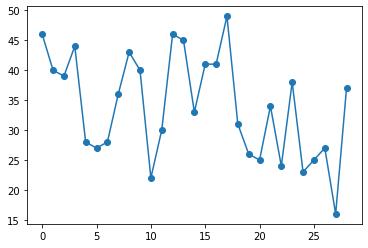

In [54]:
import matplotlib.pyplot as plt

result = [46, 86, 125, 169, 197, 224, 252, 288, 331, 371, 393, 423, 469, 514, 547, 588, 629, 678, 709, 735, 760, 794, 818, 856, 879, 904, 931, 947, 984]
result2 = [86, 125, 169, 197, 224, 252, 288, 331, 371, 393, 423, 469, 514, 547, 588, 629, 678, 709, 735, 760, 794, 818, 856, 879, 904, 931, 947, 984, 0]
final = [46]
for a, b in zip(result, result2):
  final.append(b-a)
final = final[:-1]

plt.plot(range(29), final, 'o-')
plt.show()

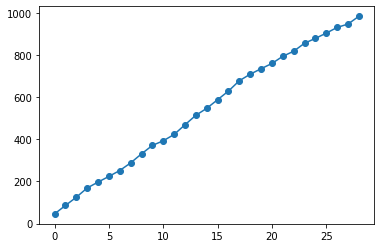

In [55]:
plt.plot(range(29), result, 'o-')
plt.show()

In [59]:
pd.Series(final).describe()

count    29.000000
mean     33.931034
std       8.762465
min      16.000000
25%      27.000000
50%      34.000000
75%      41.000000
max      49.000000
dtype: float64